# Flight Price Prediction Using Random Forest Model With Deployment

In [3]:
#Importing required libraries 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import sklearn
import pickle

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor , ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import RandomizedSearchCV , train_test_split

In [4]:
#Importing train and test dataset

df = pd.read_excel("air_train.xlsx",engine='openpyxl')
df1 = pd.read_excel("air_test.xlsx",engine='openpyxl')

#Loading train dataset

df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [5]:
#Dropping Missing Values

df.dropna(inplace = True)
df1.dropna(inplace = True)

In [6]:
#Converting string values in columns "Date_of_Journey", "Dep_Time" and"Arrival_Time" to Datetime

#For train dataset

df["Journey_month"] = pd.to_datetime(df["Date_of_Journey"]).dt.month
df["Journey_day"] = pd.to_datetime(df["Date_of_Journey"]).dt.day

df["Dep_Time_hr"] = pd.to_datetime(df["Dep_Time"]).dt.hour
df["Dep_Time_min"] = pd.to_datetime(df["Dep_Time"]).dt.minute

df["Arrival_Time_hr"] = pd.to_datetime(df["Arrival_Time"]).dt.hour
df["Arrival_Time_min"] = pd.to_datetime(df["Arrival_Time"]).dt.minute

#For test dataset

df1["Journey_month"] = pd.to_datetime(df1["Date_of_Journey"]).dt.month
df1["Journey_day"] = pd.to_datetime(df1["Date_of_Journey"]).dt.day

df1["Dep_Time_hr"] = pd.to_datetime(df1["Dep_Time"]).dt.hour
df1["Dep_Time_min"] = pd.to_datetime(df1["Dep_Time"]).dt.minute

df1["Arrival_Time_hr"] = pd.to_datetime(df1["Arrival_Time"]).dt.hour
df1["Arrival_Time_min"] = pd.to_datetime(df1["Arrival_Time"]).dt.minute

In [7]:
#Dropping insignificant columns from the train and test dataset


df.drop(["Date_of_Journey" , "Dep_Time" , "Arrival_Time","Additional_Info","Route"] , axis =1 , inplace = True)
df1.drop(["Date_of_Journey" , "Dep_Time" , "Arrival_Time","Additional_Info","Route"] , axis =1 , inplace = True)

In [8]:
#Converting Categorical Features into numerical form using LabelEncoder()

le = LabelEncoder()

#For train dataset

df["Source"] = le.fit_transform(df["Source"])
df["Destination"] = le.fit_transform(df["Destination"])

#For test dataset

df1["Source"] = le.fit_transform(df1["Source"])
df1["Destination"] = le.fit_transform(df1["Destination"])

In [9]:
# Determining no. of flights for different Airline companies in train and test dataset respectively

print(df.Airline.value_counts())   # For train dataset
print(" ")
print(df1.Airline.value_counts())  # For test dataset

Jet Airways                          3849
IndiGo                               2053
Air India                            1751
Multiple carriers                    1196
SpiceJet                              818
Vistara                               479
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Trujet                                  1
Name: Airline, dtype: int64
 
Jet Airways                          897
IndiGo                               511
Air India                            440
Multiple carriers                    347
SpiceJet                             208
Vistara                              129
Air Asia                              86
GoAir                                 46
Multiple carriers Premium economy      3
Vistara Premium economy                2
Jet Airways Business                   2
Name: Airline, 

In [10]:
#mapping no. of stops for train and test dataset respectively

stop = {
    "non-stop":0,
    "1 stop":1,
    "2 stops":2,
    "3 stops":3,
    "4 stops":4
}

df.loc[: , "Total_Stops"] = df["Total_Stops"].map(stop)    # For train dataset

df1.loc[: , "Total_Stops"] = df1["Total_Stops"].map(stop)  # For test dataset

In [11]:
#Loading train dataset
df.head()

,Airline,Source,Destination,Duration,Total_Stops,Price,Journey_month,Journey_day,Dep_Time_hr,Dep_Time_min,Arrival_Time_hr,Arrival_Time_min
0,IndiGo,0,5,2h 50m,0,3897,3,24,22,20,1,10
1,Air India,3,0,7h 25m,2,7662,1,5,5,50,13,15
2,Jet Airways,2,1,19h,2,13882,9,6,9,25,4,25
3,IndiGo,3,0,5h 25m,1,6218,12,5,18,5,23,30
4,IndiGo,0,5,4h 45m,1,13302,1,3,16,50,21,35


In [12]:
#change of duration into hr and min
#train

duration = list(df["Duration"])

for i in range(len(duration)):
    if len(duration[i].split()) != 2:    # Check if duration contains only hour or mins
        if "h" in duration[i]:
            duration[i] = duration[i].strip() + " 0m"   # Adds 0 minute
        else:
            duration[i] = "0h " + duration[i]           # Adds 0 hour

duration_hours = []
duration_mins = []
for i in range(len(duration)):
    duration_hours.append(int(duration[i].split(sep = "h")[0]))    # Extract hours from duration
    duration_mins.append(int(duration[i].split(sep = "m")[0].split()[-1]))

In [13]:
#test
duration = list(df1["Duration"])

for i in range(len(duration)):
    if len(duration[i].split()) != 2:    # Check if duration contains only hour or mins
        if "h" in duration[i]:
            duration[i] = duration[i].strip() + " 0m"   # Adds 0 minute
        else:
            duration[i] = "0h " + duration[i]           # Adds 0 hour

duration_hours_t = []
duration_mins_t = []
for i in range(len(duration)):
    duration_hours_t.append(int(duration[i].split(sep = "h")[0]))    # Extract hours from duration
    duration_mins_t.append(int(duration[i].split(sep = "m")[0].split()[-1]))

In [14]:
df["Duration_hours"] = duration_hours
df["Duration_mins"] = duration_mins

In [15]:
df1["Duration_hours"] = duration_hours_t
df1["Duration_mins"] = duration_mins_t

In [16]:
df.head()    #Loading the modified train data

,Airline,Source,Destination,Duration,Total_Stops,Price,Journey_month,Journey_day,Dep_Time_hr,Dep_Time_min,Arrival_Time_hr,Arrival_Time_min,Duration_hours,Duration_mins
0,IndiGo,0,5,2h 50m,0,3897,3,24,22,20,1,10,2,50
1,Air India,3,0,7h 25m,2,7662,1,5,5,50,13,15,7,25
2,Jet Airways,2,1,19h,2,13882,9,6,9,25,4,25,19,0
3,IndiGo,3,0,5h 25m,1,6218,12,5,18,5,23,30,5,25
4,IndiGo,0,5,4h 45m,1,13302,1,3,16,50,21,35,4,45


In [17]:
df1.head()    #Loading the modified test data

,Airline,Source,Destination,Duration,Total_Stops,Journey_month,Journey_day,Dep_Time_hr,Dep_Time_min,Arrival_Time_hr,Arrival_Time_min,Duration_hours,Duration_mins
0,Jet Airways,2,1,10h 55m,1,6,6,17,30,4,25,10,55
1,IndiGo,3,0,4h,1,12,5,6,20,10,20,4,0
2,Jet Airways,2,1,23h 45m,1,5,21,19,15,19,0,23,45
3,Multiple carriers,2,1,13h,1,5,21,8,0,21,0,13,0
4,Air Asia,0,2,2h 50m,0,6,24,23,55,2,45,2,50


In [18]:
#Dropping the "Duration" column from both the train and test datasets respectively as it is irrelevant now

df.drop(["Duration"] , axis =1 , inplace =True)
df1.drop(["Duration"] , axis =1 , inplace =True)

In [19]:

#mapping

stop = {
    "Jet Airways":0,
    "IndiGo":1,
    "Air India":2,
    "Multiple carriers":3,
    "SpiceJet":4 , "Vistara":5 ,"Air Asia":6 , "GoAir":7, 
}

df.loc[: , "Airline"] = df["Airline"].map(stop)
df1.loc[: , "Airline"] = df1["Airline"].map(stop)

In [20]:
df.isna().sum()

Airline             23
Source               0
Destination          0
Total_Stops          0
Price                0
Journey_month        0
Journey_day          0
Dep_Time_hr          0
Dep_Time_min         0
Arrival_Time_hr      0
Arrival_Time_min     0
Duration_hours       0
Duration_mins        0
dtype: int64

In [21]:
df = df[df.Airline != 'Trujet']

df = df[df.Airline != 'Multiple carriers Premium economy']
df = df[df.Airline != 'Jet Airways Business']
df = df[df.Airline != 'Vistara Premium economy']



df1 = df1[df1.Airline != 'Multiple carriers Premium economy']
df1 = df1[df1.Airline != 'Jet Airways Business']
df1 = df1[df1.Airline != 'Vistara Premium economy']

D:\Anaconda\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [22]:
df.isna().sum()

Airline             23
Source               0
Destination          0
Total_Stops          0
Price                0
Journey_month        0
Journey_day          0
Dep_Time_hr          0
Dep_Time_min         0
Arrival_Time_hr      0
Arrival_Time_min     0
Duration_hours       0
Duration_mins        0
dtype: int64

In [23]:
df.dropna(inplace = True)
df1.dropna(inplace = True)

In [24]:
df.isna().sum()

Airline             0
Source              0
Destination         0
Total_Stops         0
Price               0
Journey_month       0
Journey_day         0
Dep_Time_hr         0
Dep_Time_min        0
Arrival_Time_hr     0
Arrival_Time_min    0
Duration_hours      0
Duration_mins       0
dtype: int64

In [25]:
df1.isna().sum()

Airline             0
Source              0
Destination         0
Total_Stops         0
Journey_month       0
Journey_day         0
Dep_Time_hr         0
Dep_Time_min        0
Arrival_Time_hr     0
Arrival_Time_min    0
Duration_hours      0
Duration_mins       0
dtype: int64

In [26]:
x = df.drop(["Price"] , axis =1)
y = df.Price
x_train , x_test , y_train , y_test = train_test_split(x,y,random_state = 100 , test_size = 0.3)

In [27]:
feat = ExtraTreesRegressor()
feat.fit(x_train , y_train)

ExtraTreesRegressor()

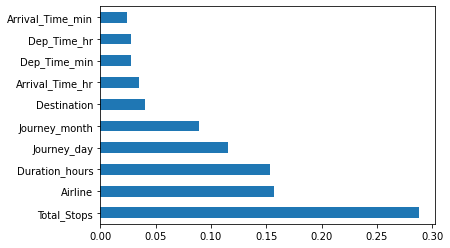

In [28]:
features = pd.Series( feat.feature_importances_ , index = x_train.columns )
features.nlargest(10).plot(kind = "barh")
plt.show()

From the plot above, we can clearly see that the feature **Total_Stops** has the highest importance.

In [29]:
##create model
lr = LinearRegression()
rfr = RandomForestRegressor()
dt = DecisionTreeRegressor()

In [30]:
print(lr.fit(x_train , y_train))
print(rfr.fit(x_train , y_train))
print(dt.fit(x_train , y_train))

LinearRegression()
RandomForestRegressor()
DecisionTreeRegressor()


In [31]:
#train acc

print(r2_score(lr.predict(x_train) , y_train))
print(r2_score(rfr.predict(x_train) , y_train))
print(r2_score(dt.predict(x_train) , y_train))

-0.11688560203520115
0.9498721945522915
0.9703741070907215


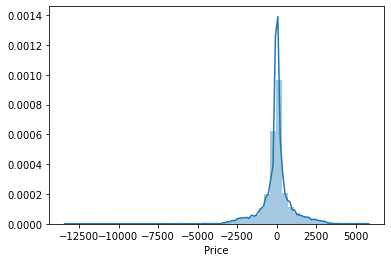

In [32]:
#checking distribution on the train dataset
sb.distplot(rfr.predict(x_train) - y_train)

We are getting a perfect **normal distribution curve** which is the ideal case.

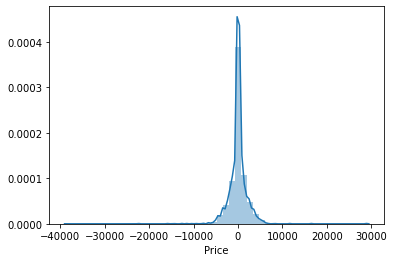

In [33]:
#checking distribution on the test dataset
sb.distplot(rfr.predict(x_test) - y_test)

For the test dataset also, we are getting a **normal distribution curve** which means that our model **Random Forest Regressor** is performing correctly

## Hyperparameter Tuning

In [34]:

rf_p = {
    
    "min_samples_split": list(range(2,11)),
    "min_samples_leaf" : list(range(1,10)),
    "max_depth":list(range(1,200)),
    "n_estimators": list(range(1,500))
}

dt_p = {
    "criterion":["mse"],
    "min_samples_split": list(range(2,11)),
    "min_samples_leaf" : list(range(1,10)),
    "max_depth":list(range(1,200))
}

In [35]:
rscv = RandomizedSearchCV(rfr , param_distributions=rf_p , cv =10 , n_iter=10  ,n_jobs = -1 , verbose = 10)

In [36]:
rscv.fit(x,y)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   47.3s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   57.0s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  2.7min remaining:    6.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.7min finished


RandomizedSearchCV(cv=10, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19, 20, 21,
                                                      22, 23, 24, 25, 26, 27,
                                                      28, 29, 30, ...],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9, 10],
                                        'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8,
                                                         9, 10, 11, 12, 13, 14,
                                                         15, 16, 17, 18, 19, 

In [37]:
rscv.best_estimator_

RandomForestRegressor(max_depth=199, min_samples_leaf=2, min_samples_split=8,
                      n_estimators=217)

In [38]:
rfr =RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=35,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=9,
                      min_weight_fraction_leaf=0.0, n_estimators=69,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [39]:
rfr.fit(x_train , y_train)
dt.fit(x_train , y_train)

DecisionTreeRegressor()

In [40]:
print(r2_score(rfr.predict(x_test) , y_test))
print(r2_score(dt.predict(x_test) , y_test))

0.7802982164266767
0.6724736383627927


In [41]:
df1.head()

,Airline,Source,Destination,Total_Stops,Journey_month,Journey_day,Dep_Time_hr,Dep_Time_min,Arrival_Time_hr,Arrival_Time_min,Duration_hours,Duration_mins
0,0.0,2,1,1,6,6,17,30,4,25,10,55
1,1.0,3,0,1,12,5,6,20,10,20,4,0
2,0.0,2,1,1,5,21,19,15,19,0,23,45
3,3.0,2,1,1,5,21,8,0,21,0,13,0
4,6.0,0,2,0,6,24,23,55,2,45,2,50


In [42]:
#Saving the model in a pickle file

file = open('main_flight_rfr.pkl', "wb")
pickle.dump(rfr , file)

In [43]:
model = open('main_flight_rfr.pkl', "rb")
forest = pickle.load(model)

In [44]:
#testing pickle file
pickle_file = forest.predict(df1.iloc[1:2 , :])

In [45]:
for contents in pickle_file:
    print(contents)

4427.988860795829


## Conclusion

Our model **Random Forest Regressor** performed well on the prediction with an **accuracy of 95% on the train data and about 80% on the test data**  